# Combining Tide and Solar Radiation to Model Intertidal Temperatures

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

from utils import *

## Load NSRDB GHI Data

First, we load some hardcoded information about our Fort Ross site, where we have access to logged intertidal temperature data <citation>.  
See [01_yearly_ghi.ipynb](01_yearly_ghi.ipynb) for how the closest NSRDB site was calculated; NOAA station ID was selected from their [website](https://tidesandcurrents.noaa.gov/tide_predictions.html) manually.

In [2]:
site = SITES['Fort Ross']
site

{'name': 'Fort Ross',
 'tz': 'America/Los_Angeles',
 'loc': (38.51265, -123.24647),
 'noaa_station_id': 9416024,
 'nsrdb_site_id': 131123}

Next we load NSRDB GHI data for 2015 and 2016, the years with the logged temperature data.  
Note that this NSRDB data was formatted with UTC timestamps, so care was taken to localize those to Fort Ross's pacific time zone.  


`get_nsrdb_data` also caches data in `/cached` to reduce queries to the NSRDB API.

In [3]:
ghi_2015 = get_nsrdb_data(2015, 'ghi', site['nsrdb_site_id'], site['tz'])
ghi_2016 = get_nsrdb_data(2016, 'ghi', site['nsrdb_site_id'], site['tz'])
ghi_extended = pd.concat([ghi_2015, ghi_2016])
ghi_extended.head()

Found cached/site-131123-data-2015.pkl, loading...
Found cached/site-131123-data-2016.pkl, loading...


2014-12-31 16:00:00-08:00    135
2014-12-31 16:30:00-08:00     57
2014-12-31 17:00:00-08:00      0
2014-12-31 17:30:00-08:00      0
2014-12-31 18:00:00-08:00      0
dtype: int16

## Load Logged Temperature Data
The data includes two sets of temperature loggers, at high and low intertidal elevation. We use the high loggers for our analysis.

In [4]:
hot_rocks_df = get_hot_rocks_data()

# apply boolean mask to get high elevation data, then select the temperature series specifically
year_temps_high = hot_rocks_df[hot_rocks_df['elev'] == 'high']['temp']
year_temps_high.head()

dt
2015-06-19 00:02:00-07:00    11.0
2015-06-19 00:04:00-07:00    11.0
2015-06-19 00:05:00-07:00    10.5
2015-06-19 00:05:00-07:00    11.0
2015-06-19 00:07:00-07:00    11.0
Name: temp, dtype: float64

## Model Baseline: Calculate Correlation between GHI and Temperature

Calculate daily maximum values from logged temperature data and GHI data.

<Axes: title={'center': 'Rough Plot of Max Temperatures and Corresponding Max GHI Values'}>

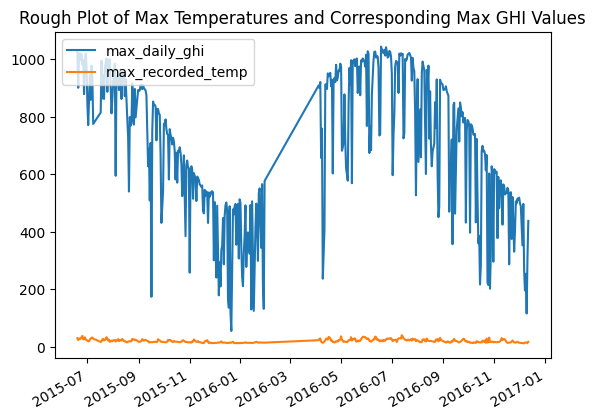

In [15]:
max_daily_ghi = ghi_extended.resample('D').max()
max_recorded_temp = year_temps_high.resample('D').max()

# Confirm timezones are the same before we merge data into one frame
assert max_recorded_temp.index.tz == max_daily_ghi.index.tz
df = pd.concat([max_daily_ghi, max_recorded_temp], axis=1)
df.columns = ['max_daily_ghi', 'max_recorded_temp']

# Drop rows where any of the values are NaN (i.e., days where temperature was not recorded at the site).
df = df.dropna()

# Quick sanity check plot for the data/timeframe
df.plot(title="Rough Plot of Max Temperatures and Corresponding Max GHI Values")

Perform linear regression analysis comparing the maximum daily GHI and the maximum daily recorded temperature at the site:

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['max_daily_ghi'], df['max_recorded_temp'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Slope: 0.015579596664309001
Intercept: 8.274284154821197
R-squared: 0.4659770546878366
P-value: 4.174634751305829e-64
Standard error: 0.0007810367725489948


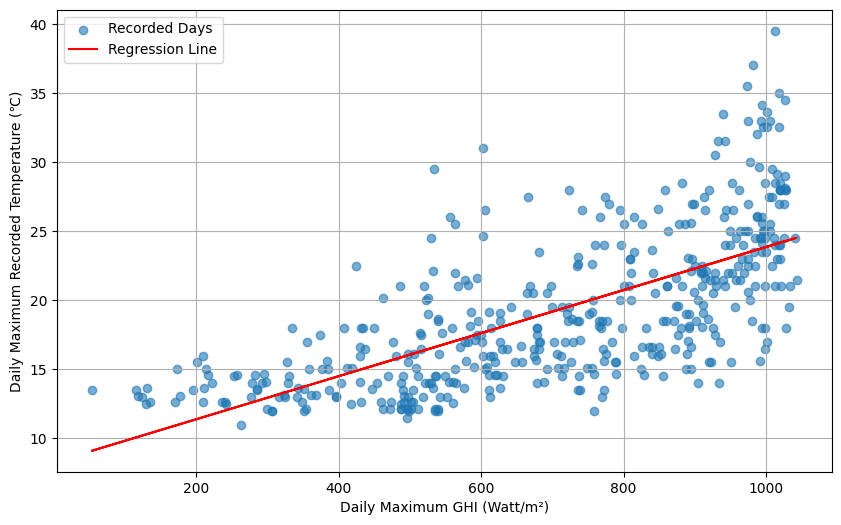

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(df['max_daily_ghi'], df['max_recorded_temp'], alpha=0.6, label='Recorded Days')

# Calculate and add regression line
x = df['max_daily_ghi']
y = intercept + slope * x
plt.plot(x, y, color='red', label='Regression Line')

# Add Labels and Formatting
plt.xlabel('Daily Maximum GHI (Watt/m²)')
plt.ylabel('Daily Maximum Recorded Temperature (℃)')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


## Commentary

The correlation between GHI and logged intertidal temperature calculated above is fairly intuitive; high sun exposure often cooccurs with a high recorded temperature by the loggers.

However, an R-Squared of ~.47 indicates that there is more variance to be explained here.

For example, some days with a max recorded GHI in the 900-1000 range experienced temperatures upwards of 30℃, while others peaked lower than 20℃.

Below, we investigate whether water level can be incorporated to explain some of this variance.

## Get NOAA Tide Predictions via API

We request a time period padded with one day on each end for interpolation purposes, explained below.

In [8]:
both_years_padded = [get_year_padded(2015)[0], get_year_padded(2016)[1]]
print(both_years_padded)
tide_series = get_noaa_tide_preds(site, both_years_padded)

['20141231', '20170101']


### Tide Interpolation

The data we get from NOAA will be daily high and low tide values. To compare and combine the tide level and the higher resolution GHI data, we need to interpolate the water level between the high and low predicted tides.

A simple cubic interpolation function was adequate for this initial investigation; future work could:
- investigate possible inaccuracies introduced by these interpolated predicted tide levels.
- investigate using logged historical water levels if available.

<Axes: title={'center': 'Interpolated Tide Predictions, Visualized'}, xlabel='t'>

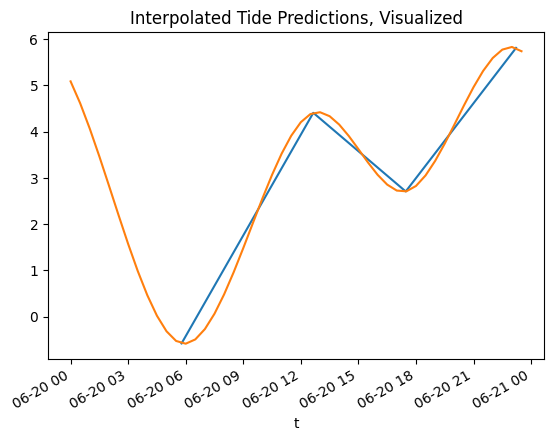

In [19]:
# Interpolate tide high/low data to get a tide value for every timestamp in the ghi data series
tide_high_res = interpolate_tide_preds(tide_series, ghi_extended.index)

EXAMPLE_DATE = '2016-06-20'
tide_series[EXAMPLE_DATE].plot()
tide_high_res[EXAMPLE_DATE].plot(title="Interpolated Tide Predictions, Visualized")

## Scale GHI Data According to Corresponding Tide Level

By incorporating tide level and GHI data, we create a simple model of intertidal temperature.

First, we normalize

### Normalize Tide Data
We want to scale the solar radiation according to how low the tide was, so with our tide data currently in the range 0-1 where 0 is the lowest tide, we need to invert that so 0 is the highest tide, meaning the least solar radiation is getting absorbed.

<Axes: >

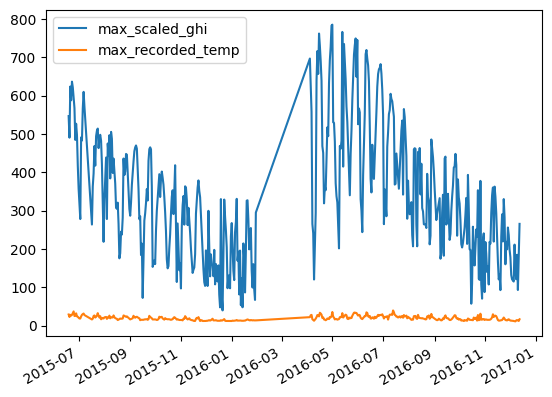

In [10]:


# Normalize tide data to a 0-1 scale based on highest and lowest observed values over hot rocks data collection period
min_val, max_val = tide_high_res.min(), tide_high_res.max()
tide_values_normalized = (tide_high_res - min_val) / (max_val - min_val)

# Then "flip" the values so 1 is low tide, 0 is high tide
tide_values_inverted = 1 - tide_values_normalized

# Just making sure we didn't mess up the data shape, before we try to multiply
assert tide_values_inverted.shape == ghi_extended.shape
tide_scaled_ghi = tide_values_inverted * ghi_extended

# Resample logged temperature data and tide-scaled ghi data to daily maximum values
max_scaled_ghi = tide_scaled_ghi.resample('D').max()
max_recorded_temp = year_temps_high.resample('D').max()

# Confirm timezones are the same before we merge data into one frame
assert max_recorded_temp.index.tz == max_scaled_ghi.index.tz
df = pd.concat([max_scaled_ghi, max_recorded_temp], axis=1)
df.columns = ['max_scaled_ghi', 'max_recorded_temp']

# Drop rows where any of the values is NaN (this should only be days where there's no hot rocks data)
df = df.dropna()

# Quick sanity check plot for the data/timeframe
df.plot()

In [11]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['max_scaled_ghi'], df['max_recorded_temp'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Slope: 0.027602904496784517
Intercept: 9.786316316414487
R-squared: 0.6861106634741813
P-value: 8.291743650502403e-117
Standard error: 0.000874306199613332


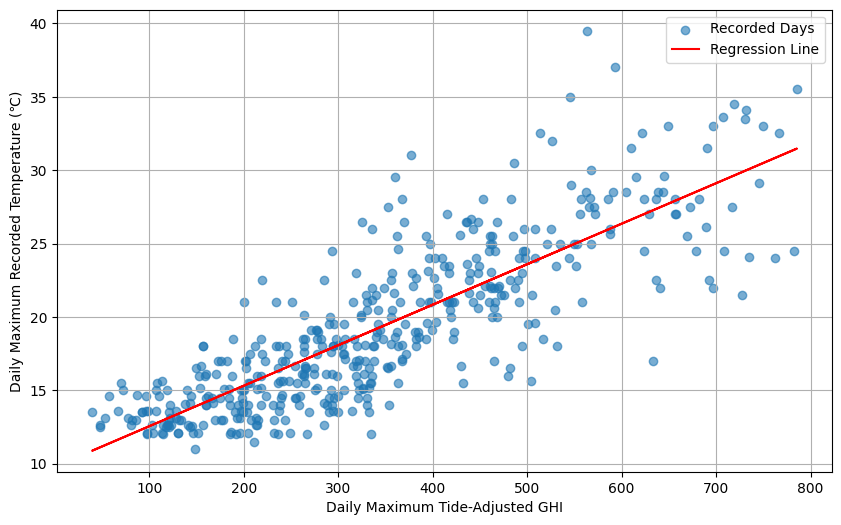

In [12]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['max_scaled_ghi'], df['max_recorded_temp'], alpha=0.6, label='Recorded Days')

# Calculate and add regression line
x = df['max_scaled_ghi']
y = intercept + slope * x
plt.plot(x, y, color='red', label='Regression Line')

# Add plot title and labels
# plt.title('Analysis of Heat Exposure in the Intertidal Zone')
plt.xlabel('Daily Maximum Tide-Adjusted GHI (Watt/m²)')
plt.ylabel('Daily Maximum Recorded Temperature (℃)')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


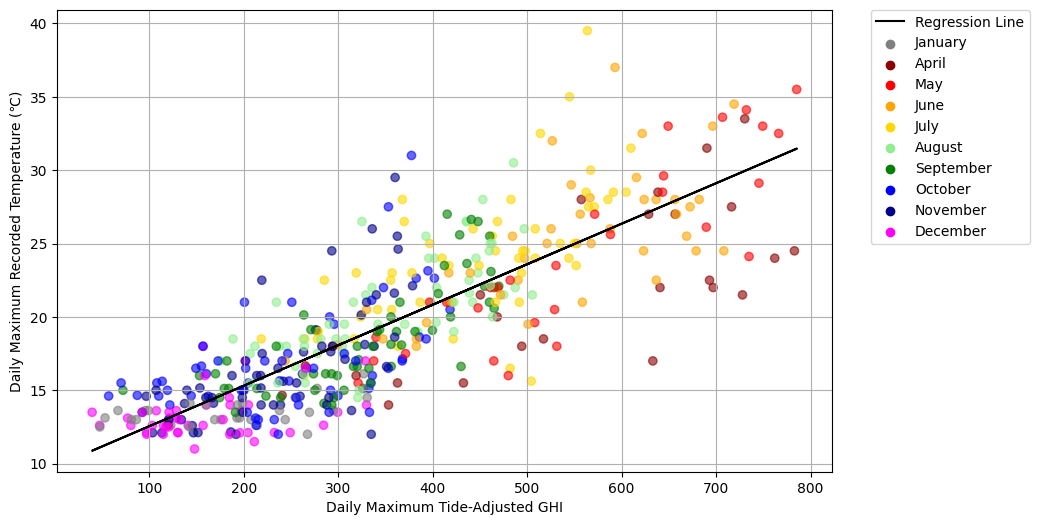

In [13]:


# Map the colors to the entries in the frame
colors = df.index.month.map(lambda x: MONTH_COLORS[x])

# Create a scatter plot with specific month colors
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['max_scaled_ghi'], df['max_recorded_temp'], color=colors, alpha=0.6)

# Add regression line
x = df['max_scaled_ghi']
y = intercept + slope * x
plt.plot(x, y, color='black', label='Regression Line')  # Use a neutral color for the line

# Add invisible points for creating the legend for months
for month, color in MONTH_COLORS.items():
    plt.scatter([], [], color=color, label=pd.to_datetime(month, format='%m').month_name())

plt.xlabel('Daily Maximum Tide-Adjusted GHI')
plt.ylabel('Daily Maximum Recorded Temperature (℃)')
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()